<font color=red size=6>PREDICTIONS</font>

**Pere Mayol Carbonell, NIU:1669503** <br>
Paper on RNNs and time series forcasting - https://www.sciencedirect.com/science/article/abs/pii/S0169207020300996

Video on LSTMs for TSF and taking into account attention - https://www.youtube.com/watch?v=DKQerT3ybls

In [200]:
#import everything we need
import pandas as p
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')#just to make the plots look better.

#regarding the training and validation of thje data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [201]:
#Read the data and print the first 10 elements to check its okay.
data_EE = p.read_csv('/content/Consum-energia-Q-2018-2023-horari.csv')
data_EE.head(10)

,Date,Hour,Q-Enginyeria-Total [kWh]
0,1/1/2018,00:00,177.00
1,1/1/2018,01:00,177.44
2,1/1/2018,02:00,176.57
3,1/1/2018,03:00,174.98
4,1/1/2018,04:00,174.51
5,1/1/2018,05:00,191.13
6,1/1/2018,06:00,198.94
7,1/1/2018,07:00,203.42
8,1/1/2018,08:00,197.41
9,1/1/2018,09:00,195.12


In [202]:
new_row = {"Date": "5/31/2024", "Hour": "14:00", "Q-Enginyeria-Total [kWh]": 200.00}
new_data = pd.DataFrame([new_row])

# Use pd.concat() to append the new row
data_EE = pd.concat([data_EE, new_data], ignore_index=True)

<font color=red size=5>Data Viusalitzation & PreProcessing</font>

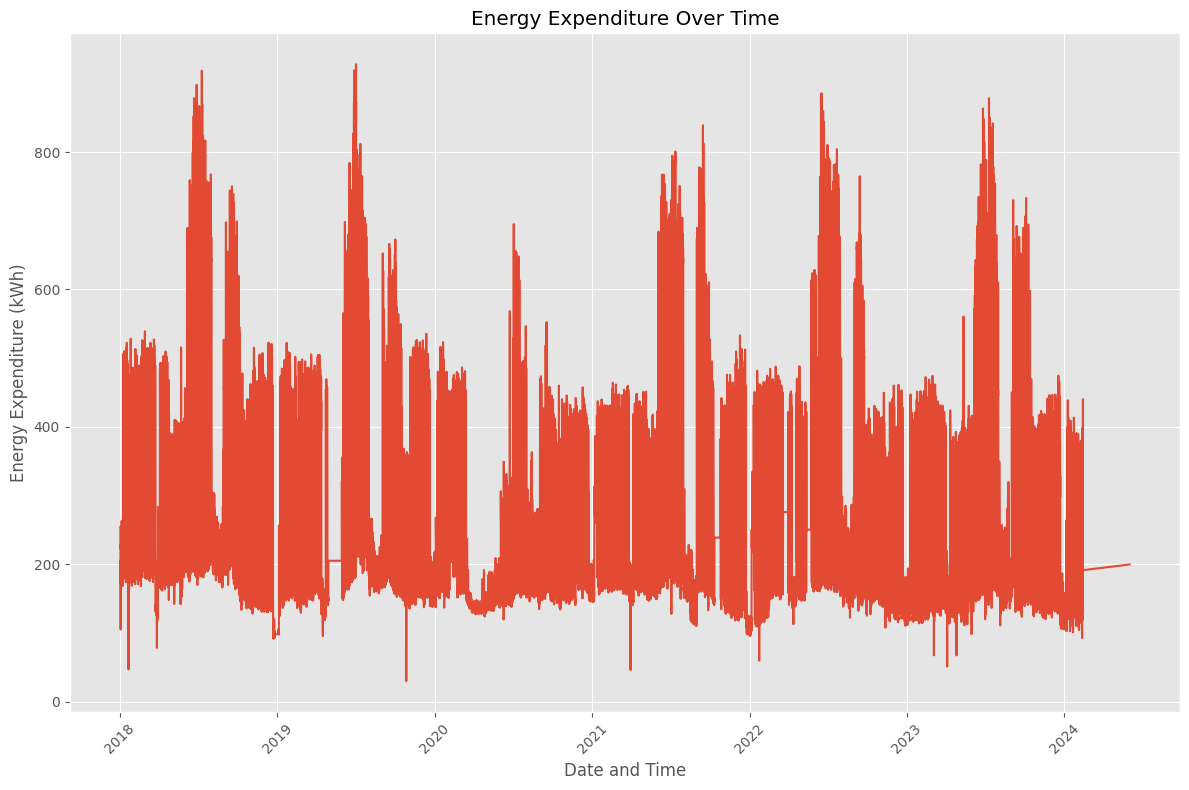

In [203]:
#For plotting Energy Expenditure over the years and see the overall behaviour.
data_EE['DateTime'] = p.to_datetime(data_EE['Date'] + ' ' + data_EE['Hour']) #Join the Date and Hour to represent the expenditure over Time

plt.figure(figsize=(12, 8))
plt.plot(data_EE['DateTime'], data_EE['Q-Enginyeria-Total [kWh]'])
plt.title('Energy Expenditure Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy Expenditure (kWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Daily mean expenditure for 4 2018 : 191264.5 kWh
Daily mean expenditure for 4 2019 : 158880.15 kWh
Daily mean expenditure for 4 2020 : 99995.66 kWh
Daily mean expenditure for 4 2021 : 181121.23 kWh
Daily mean expenditure for 4 2022 : 163396.12 kWh
Daily mean expenditure for 4 2023 : 133327.44 kWh
Daily mean expenditure for 4 2024 : 0.0 kWh


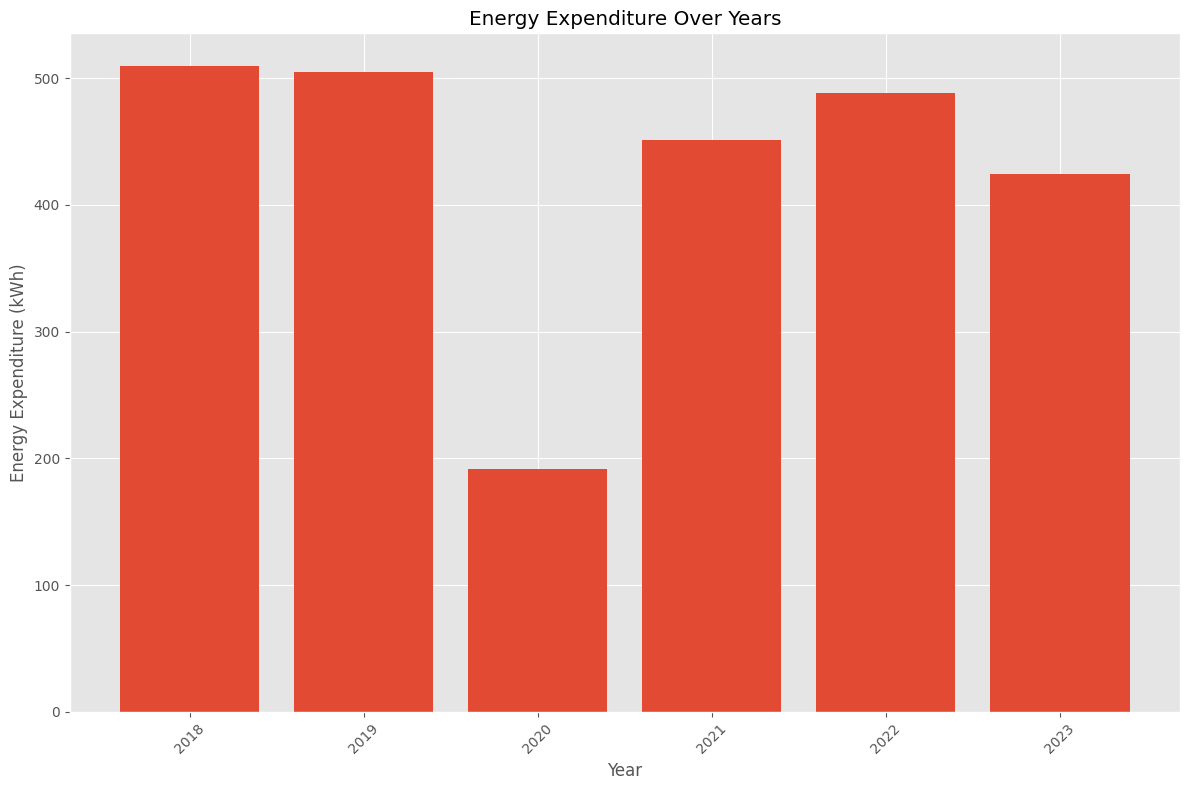

{2018: 191264.5, 2019: 158880.15, 2020: 99995.66, 2021: 181121.23, 2022: 163396.12, 2023: 133327.44, 2024: 0.0}


In [204]:
#This function returns the comparison over the years of the desired month.
def get_consumption_month(month: int, dataset: object, plot: bool):

    dataset['Date'] = p.to_datetime(dataset['Date'], format='%m/%d/%Y')

    # Extract year and month components from the 'Date' column
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)

    years = [2018,2019,2020,2021,2022,2023,2024]
    Consumptions = {}
    for year in years:
        month_year = data_EE[(data_EE['Year'] == year) & (data_EE['Month'] == month)]
        expenditure = month_year['Q-Enginyeria-Total [kWh]'].sum()
        Consumptions[year]= expenditure
        Total_consumptions = data_EE[(data_EE['Month'] == month)]

        print("Daily mean expenditure for", month, year, ":", expenditure, "kWh")

    if plot == True:
        plt.figure(figsize=(12, 8))  # Adjust figure size as needed
        plt.bar(Total_consumptions['Date'].dt.year, Total_consumptions['Q-Enginyeria-Total [kWh]'])
        plt.title('Energy Expenditure Over Years')
        plt.xlabel('Year')
        plt.ylabel('Energy Expenditure (kWh)')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show()

    return Consumptions


consuptions = get_consumption_month(4,data_EE, plot=True)
print(consuptions)


In [205]:
#Fix the Date and Hour format so its usable
data_EE['Hour'] = data_EE['Hour'].apply(lambda x: ''.join(x.split(':')))
data_EE['Date'] = data_EE['Date'].apply(lambda x: x.strftime('%d%m%Y'))
data_EE.head()

,Date,Hour,Q-Enginyeria-Total [kWh],DateTime,Year,Month
0,01012018,0000,177.00,2018-01-01 00:00:00,2018,1
1,01012018,0100,177.44,2018-01-01 01:00:00,2018,1
2,01012018,0200,176.57,2018-01-01 02:00:00,2018,1
3,01012018,0300,174.98,2018-01-01 03:00:00,2018,1
4,01012018,0400,174.51,2018-01-01 04:00:00,2018,1


In [206]:
#To create a new feature based on which day of the week it was at each date.
data_EE['Date'] = p.to_datetime(data_EE['Date'], format='%d%m%Y')

data_EE['Day_of_Week'] = data_EE['Date'].dt.dayofweek

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_EE['Day_of_Week'] = data_EE['Day_of_Week'].map(lambda x: day_names[x])


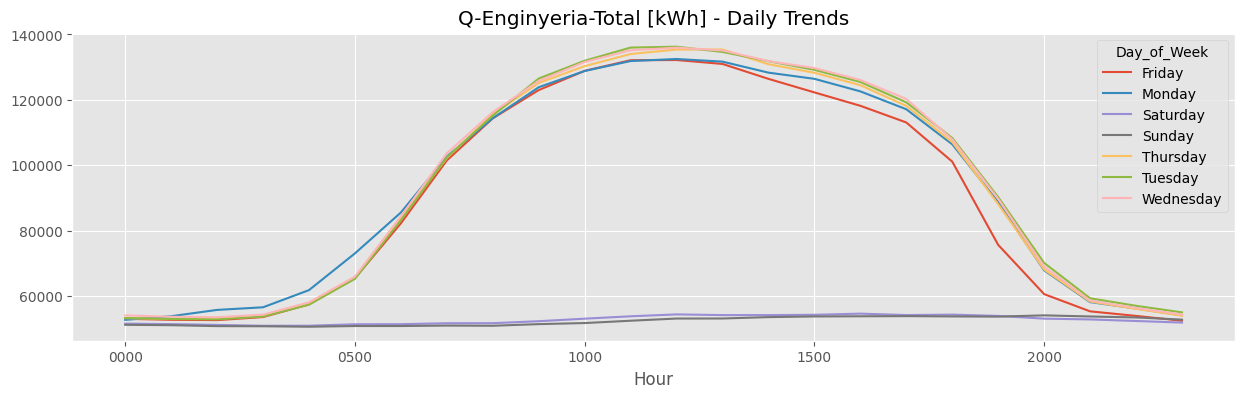

In [207]:
_ = data_EE.pivot_table(index=data_EE['Hour'],
                     columns='Day_of_Week',
                     values='Q-Enginyeria-Total [kWh]',
                     aggfunc='sum').plot(figsize=(15,4),
                     title='Q-Enginyeria-Total [kWh] - Daily Trends')

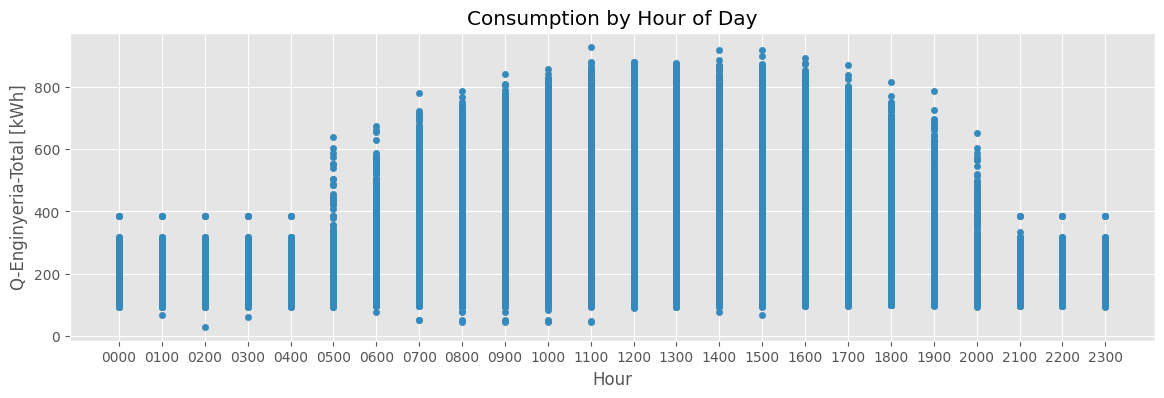

In [208]:
_ = data_EE[['Q-Enginyeria-Total [kWh]','Hour']].plot(x='Hour',
                                     y='Q-Enginyeria-Total [kWh]',
                                     kind='scatter',
                                     figsize=(14,4),
                                     title='Consumption by Hour of Day')

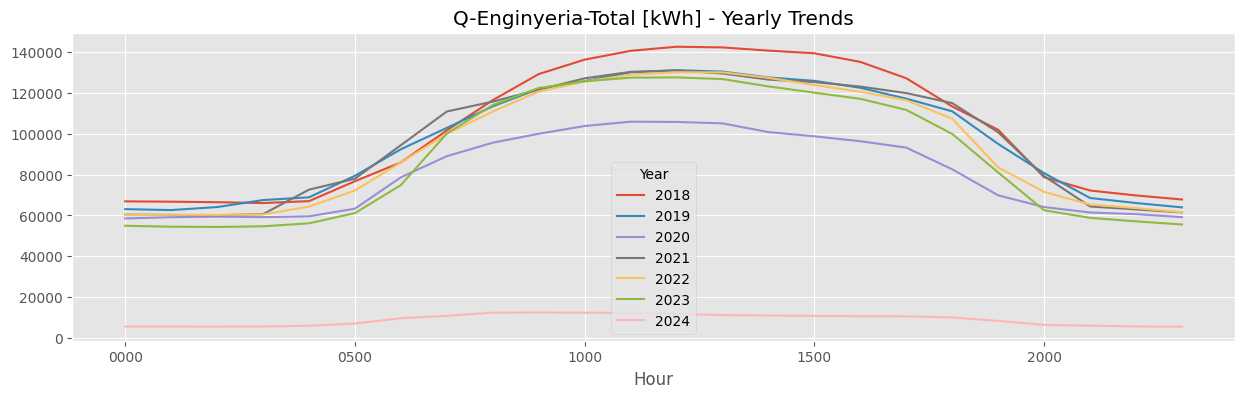

In [209]:
_ = data_EE.pivot_table(index=data_EE['Hour'],
                     columns='Year',
                     values='Q-Enginyeria-Total [kWh]',
                     aggfunc='sum').plot(figsize=(15,4),
                     title='Q-Enginyeria-Total [kWh] - Yearly Trends')

In [210]:
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(x - min_val) / (max_val - min_val) for x in column]
    return normalized_column


#Normalize the 'Q-Enginyeria-Total [kWh]', to understand better the results and make it simpler.
#data_EE['Q-Enginyeria-Total [kWh]'] = min_max_normalize(data_EE['Q-Enginyeria-Total [kWh]'])

In [211]:
#Change day of the week from categorical to an integrer depending on which day it is.
data_EE['Day_of_Week'] = p.factorize(data_EE['Day_of_Week'])[0] + 1
data_EE['Day'] = data_EE['Date'].dt.day
data_EE.head(200)

,Date,Hour,Q-Enginyeria-Total [kWh],DateTime,Year,Month,Day_of_Week,Day
0,2018-01-01,0000,177.00,2018-01-01 00:00:00,2018,1,1,1
1,2018-01-01,0100,177.44,2018-01-01 01:00:00,2018,1,1,1
2,2018-01-01,0200,176.57,2018-01-01 02:00:00,2018,1,1,1
3,2018-01-01,0300,174.98,2018-01-01 03:00:00,2018,1,1,1
4,2018-01-01,0400,174.51,2018-01-01 04:00:00,2018,1,1,1
...,...,...,...,...,...,...,...,...
195,2018-01-09,0300,192.05,2018-01-09 03:00:00,2018,1,2,9
196,2018-01-09,0400,196.69,2018-01-09 04:00:00,2018,1,2,9
197,2018-01-09,0500,219.47,2018-01-09 05:00:00,2018,1,2,9
198,2018-01-09,0600,332.88,2018-01-09 06:00:00,2018,1,2,9


<font color=red size=5>Checking for Anomalies and Outliers</font>

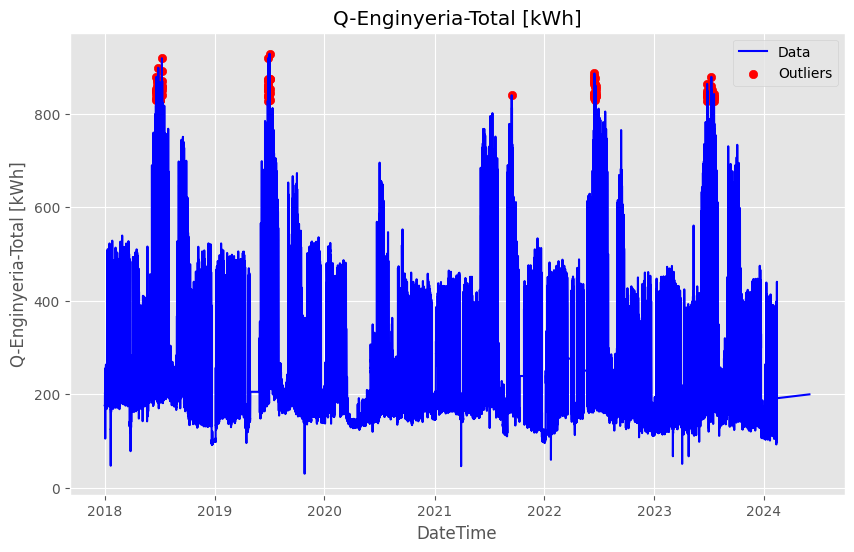

In [212]:
#Check for outliers and anomalies.
# Calculate Z-scores
data_EE['Z_score'] = (data_EE['Q-Enginyeria-Total [kWh]'] - data_EE['Q-Enginyeria-Total [kWh]'].mean()) / data_EE['Q-Enginyeria-Total [kWh]'].std()

# Define threshold for outliers
threshold = 4  # Adjust this threshold as needed

# Identify outliers
outliers = data_EE[data_EE['Z_score'].abs() > threshold]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data_EE['DateTime'], data_EE['Q-Enginyeria-Total [kWh]'], color='blue', label='Data')
plt.scatter(outliers['DateTime'], outliers['Q-Enginyeria-Total [kWh]'], color='red', label='Outliers')
plt.title('Q-Enginyeria-Total [kWh]')
plt.xlabel('DateTime')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.legend()
plt.grid(True)
plt.show()

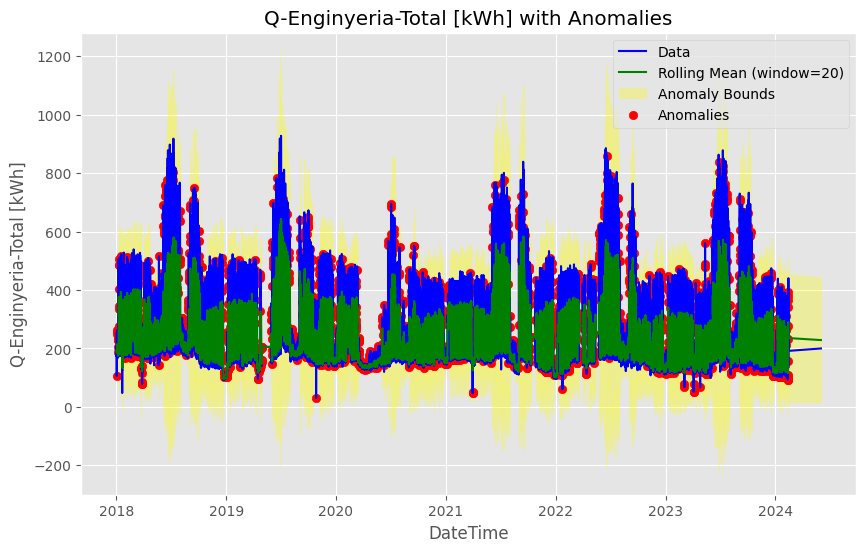

In [213]:

# Calculate rolling mean and standard deviation
window_size = 20 # Adjust window size as needed
rolling_mean = data_EE['Q-Enginyeria-Total [kWh]'].rolling(window=window_size).mean()
rolling_std = data_EE['Q-Enginyeria-Total [kWh]'].rolling(window=window_size).std()

# Calculate upper and lower bounds for anomalies
lower_bound = rolling_mean - 2 * rolling_std
upper_bound = rolling_mean + 2 * rolling_std

# Find anomalies
anomalies = data_EE[(data_EE['Q-Enginyeria-Total [kWh]'] < lower_bound) | (data_EE['Q-Enginyeria-Total [kWh]'] > upper_bound)]

# Plot the data and anomalies
plt.figure(figsize=(10, 6))
plt.plot(data_EE['DateTime'], data_EE['Q-Enginyeria-Total [kWh]'], color='blue', label='Data')
plt.plot(data_EE['DateTime'], rolling_mean, color='green', label='Rolling Mean (window={})'.format(window_size))
plt.fill_between(data_EE['DateTime'], lower_bound, upper_bound, color='yellow', alpha=0.3, label='Anomaly Bounds')
plt.scatter(anomalies['DateTime'], anomalies['Q-Enginyeria-Total [kWh]'], color='red', label='Anomalies')
plt.title('Q-Enginyeria-Total [kWh] with Anomalies')
plt.xlabel('DateTime')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.legend()
plt.grid(True)
plt.show()


<font color=red size=8>Training</font>

<font color=blue size=6>LSTM</font>

In [214]:
data_EE.head()

,Date,Hour,Q-Enginyeria-Total [kWh],DateTime,Year,Month,Day_of_Week,Day,Z_score
0,2018-01-01,0000,177.00,2018-01-01 00:00:00,2018,1,1,1,-0.542151
1,2018-01-01,0100,177.44,2018-01-01 01:00:00,2018,1,1,1,-0.539075
2,2018-01-01,0200,176.57,2018-01-01 02:00:00,2018,1,1,1,-0.545156
3,2018-01-01,0300,174.98,2018-01-01 03:00:00,2018,1,1,1,-0.556270
4,2018-01-01,0400,174.51,2018-01-01 04:00:00,2018,1,1,1,-0.559555


In [215]:
#Create a new feature for the season.
def get_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4

data_EE['Season'] = data_EE['Month'].apply(get_season)

print(data_EE.head())


        Date  Hour  Q-Enginyeria-Total [kWh]            DateTime  Year  Month  \
0 2018-01-01  0000                    177.00 2018-01-01 00:00:00  2018      1   
1 2018-01-01  0100                    177.44 2018-01-01 01:00:00  2018      1   
2 2018-01-01  0200                    176.57 2018-01-01 02:00:00  2018      1   
3 2018-01-01  0300                    174.98 2018-01-01 03:00:00  2018      1   
4 2018-01-01  0400                    174.51 2018-01-01 04:00:00  2018      1   

   Day_of_Week  Day   Z_score  Season  
0            1    1 -0.542151       1  
1            1    1 -0.539075       1  
2            1    1 -0.545156       1  
3            1    1 -0.556270       1  
4            1    1 -0.559555       1  


In [216]:
# Separate data into train and test sets
data_train = data_EE[data_EE['Date'] <= "2021-09-09"].copy()
data_test = data_EE[data_EE['Date'] > "2021-09-09"].copy()

# Define feature and target variable names
X = ['Year', 'Day', 'Month', 'Day_of_Week', 'Season', 'Z_score']
Y = ['Q-Enginyeria-Total [kWh]']

# Extract features (X) and target variable (Y) for train and test sets
train_x = data_train[X].copy()
train_y = data_train[Y].copy()
test_x = data_test[X].copy()
test_y = data_test[Y].copy()

# Verify the shapes of the datasets
print(f"Train X shape: {train_x.shape} and Train X: {train_x}")
print(f"Train Y shape: {train_y.shape} and Train Y: {train_y}")
print(f"Test X shape: {test_x.shape} and Test X: {test_x}")
print(f"Test Y shape: {test_y.shape} and Test Y: {test_y}")


Train X shape: (32351, 6) and Train X:        Year  Day  Month  Day_of_Week  Season   Z_score
0      2018    1      1            1       1 -0.542151
1      2018    1      1            1       1 -0.539075
2      2018    1      1            1       1 -0.545156
3      2018    1      1            1       1 -0.556270
4      2018    1      1            1       1 -0.559555
...     ...  ...    ...          ...     ...       ...
32346  2021    9      9            4       4  1.918014
32347  2021    9      9            4       4  0.773591
32348  2021    9      9            4       4 -0.475119
32349  2021    9      9            4       4 -0.511396
32350  2021    9      9            4       4 -0.585207

[32351 rows x 6 columns]
Train Y shape: (32351, 1) and Train Y:        Q-Enginyeria-Total [kWh]
0                        177.00
1                        177.44
2                        176.57
3                        174.98
4                        174.51
...                         ...
32346       

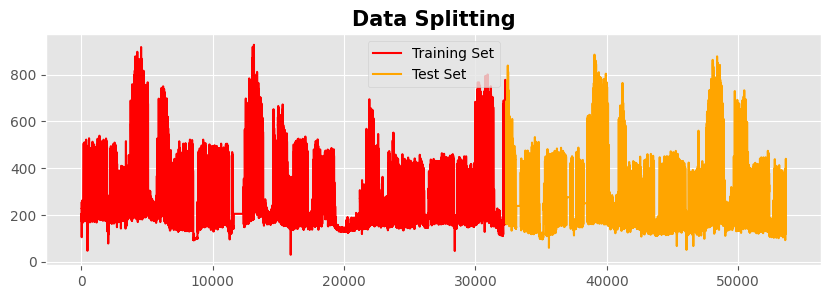

In [217]:
#Show Global Active Power from Test and Train Datasets
plt.figure(figsize = (10, 3))
data_train["Q-Enginyeria-Total [kWh]"].plot(label = "Training Set", color = "Red")
data_test["Q-Enginyeria-Total [kWh]"].plot(label  = "Test Set", color = "Orange")
plt.title("Data Splitting", weight = "bold", fontsize = 15)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training vs Test Set')

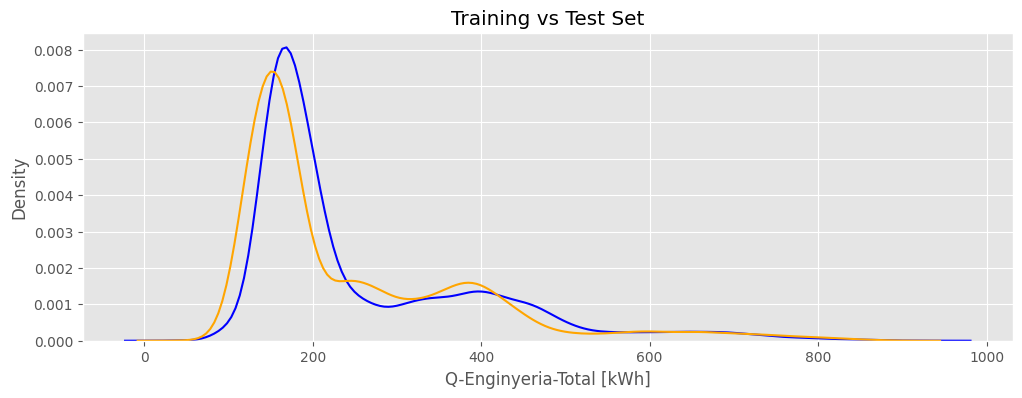

In [218]:
plt.figure(figsize=(12,4))
sns.kdeplot(data_train['Q-Enginyeria-Total [kWh]'], label  = "Training Set", color = "blue")
sns.kdeplot(data_test['Q-Enginyeria-Total [kWh]'], label  = "Test Set", color = "orange")
plt.xlabel("Q-Enginyeria-Total [kWh]")
plt.title("Training vs Test Set")

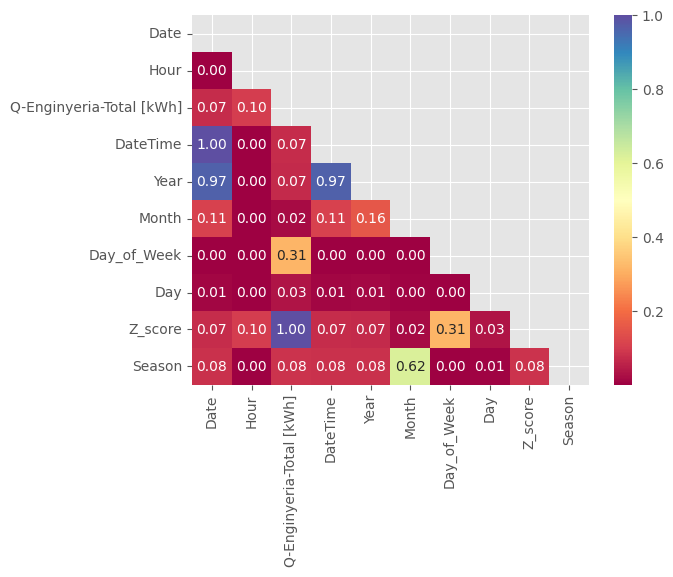

In [219]:
plt.figure()
correlations = data_train.corr().abs()
mask = np.triu(np.ones_like(correlations, dtype = "bool"))
sns.heatmap(correlations, annot = True, fmt = ".2f", cmap = "Spectral", mask = mask)
plt.show()

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


506/506 [==============================] - 9s 9ms/step - loss: 0.0318 - val_loss: 0.0107
Epoch 2/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0101 - val_loss: 0.0053
Epoch 3/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 4/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0074 - val_loss: 0.0025
Epoch 5/25
506/506 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0015
Epoch 6/25
506/506 [==============================] - 3s 6ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 7/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 8/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 9/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 10/25
506/506 [==============================] - 2s 4ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 11/2

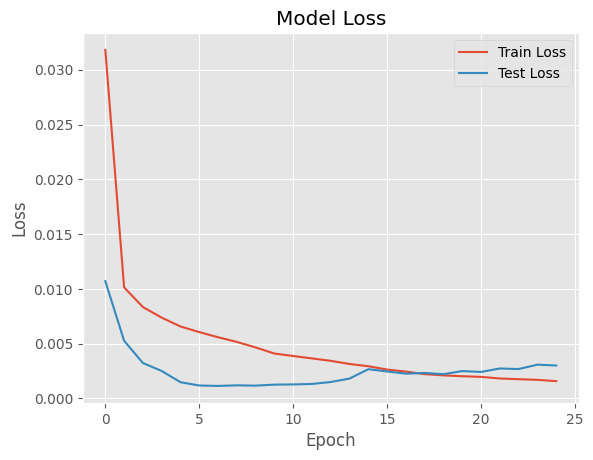

In [220]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

# Convert DataFrame to numpy arrays
train_X_values = train_x.values
train_Y_values = train_y.values
test_X_values = test_x.values
test_Y_values = test_y.values

# Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

train_X_scaled = scaler_X.fit_transform(train_X_values)
train_Y_scaled = scaler_Y.fit_transform(train_Y_values)
test_X_scaled = scaler_X.transform(test_X_values)
test_Y_scaled = scaler_Y.transform(test_Y_values)

# Reshape input data to be 3D for LSTM [samples, timesteps, features]
train_X_reshaped = np.reshape(train_X_scaled, (train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_reshaped = np.reshape(test_X_scaled, (test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))

learning_rate = 1e-3 # Set your desired learning rate here
optimizer_lstm = Adam(learning_rate=learning_rate)

# Build LSTM model with dropout
model = Sequential()
model.add(LSTM(units=7, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1))
model.compile(optimizer=optimizer_lstm, loss='mean_squared_error')

model_save_path = '/content/model.h5'
model.save(model_save_path)

# Train the model and capture history
history = model.fit(train_X_reshaped, train_Y_scaled, epochs=25, batch_size=64, verbose=1, validation_data=(test_X_reshaped, test_Y_scaled))

# Make predictions
train_predict = model.predict(train_X_reshaped)
test_predict = model.predict(test_X_reshaped)

# Inverse transform predictions
train_predict = scaler_Y.inverse_transform(train_predict)
test_predict = scaler_Y.inverse_transform(test_predict)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_y, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_y, test_predict))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


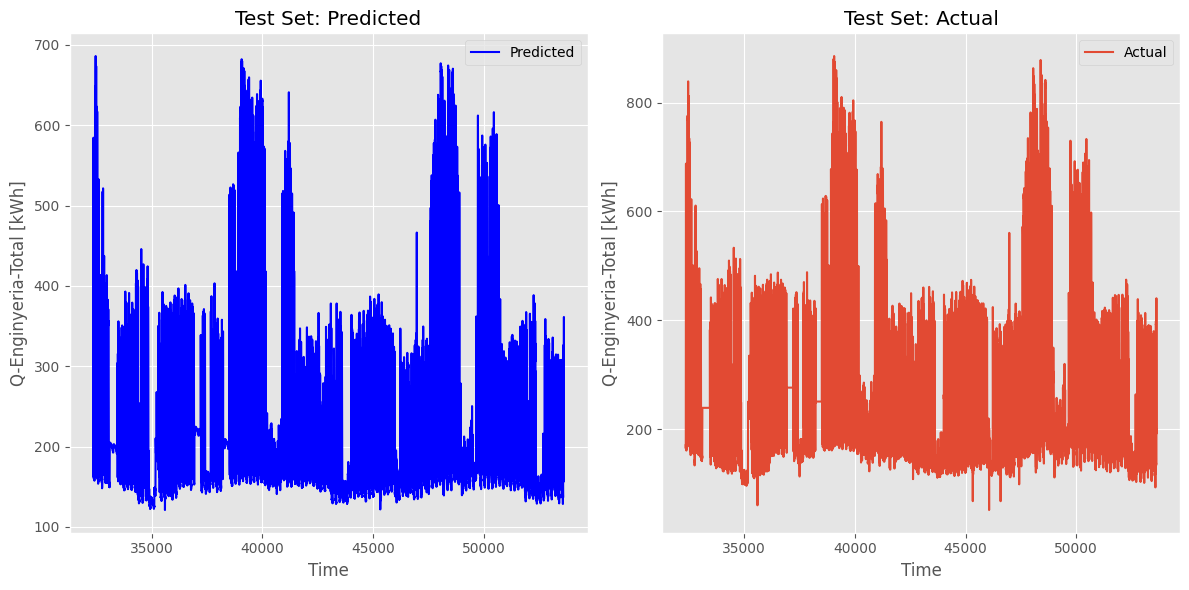

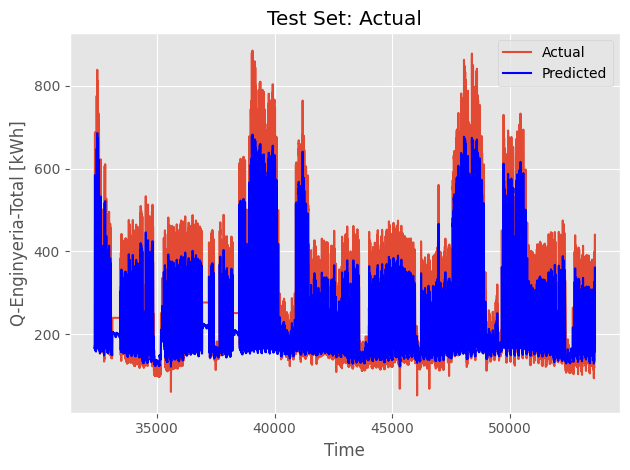

In [221]:
# Plot the predictions
plt.figure(figsize=(12, 6))

# Test set
plt.subplot(1, 2, 1)
plt.plot(test_y.index, test_predict, label='Predicted', color='blue')
plt.title('Test Set: Predicted')
plt.xlabel('Time')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.legend()

# Test set
plt.subplot(1, 2, 2)
plt.plot(test_y.index, test_y, label='Actual')
plt.title('Test Set: Actual')
plt.xlabel('Time')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(test_y.index, test_y, label='Actual')
plt.plot(test_y.index, test_predict, label='Predicted', color='blue')
plt.title('Test Set: Actual')
plt.xlabel('Time')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.legend()

plt.tight_layout()
plt.show()

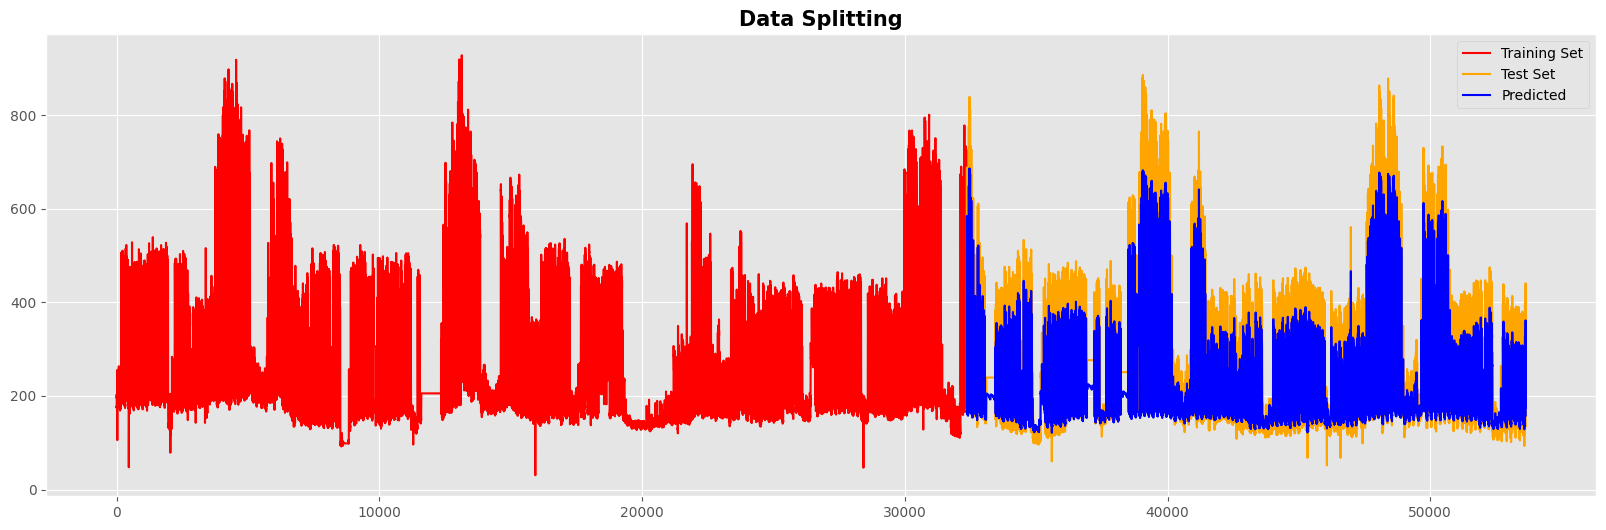

In [222]:
plt.figure(figsize = (20,6))
data_train["Q-Enginyeria-Total [kWh]"].plot(label = "Training Set", color = "Red")
data_test["Q-Enginyeria-Total [kWh]"].plot(label  = "Test Set", color = "Orange")
plt.plot(test_y.index, test_predict, label='Predicted', color='blue')
plt.title("Data Splitting", weight = "bold", fontsize = 15)
plt.legend()
plt.show()

In [223]:
print(f'The lenght of Predictions==>{len(test_predict)}')
print(f'The lenght of Actual test==>{len(test_Y_values)}')

The lenght of Predictions==>21279
The lenght of Actual test==>21279


In [224]:
print(test_predict[32])
print(test_Y_values[32])
print(test_predict)

[160.3626]
[161.99]
[[166.59593]
 [165.36298]
 [165.63382]
 ...
 [361.3661 ]
 [180.3691 ]
 [174.83682]]


In [225]:
values = []

for i in range(len(test_predict)):
  key = test_Y_values[i].tolist()[0]
  value = test_predict[i].tolist()[0]
  values.append([key,value])


In [226]:
import pandas as pd
df = pd.DataFrame(values, columns=['Value', 'Prediction'])

In [227]:
df.head()

,Value,Prediction
0,170.47,166.595932
1,167.31,165.362976
2,168.01,165.633820
3,164.74,164.378723
4,168.61,165.866913


In [228]:
from datetime import datetime,timedelta

# Initial date and time
initial_test_day = '2021-09-10'  # in format year, month, day
initial_test_time = '00:00'  # in format hour, minute

# Combine date and time into a single datetime object
current_datetime = datetime.strptime(initial_test_day + ' ' + initial_test_time, '%Y-%m-%d %H:%M')

datetime_values = []

for i in range(len(df)):
    datetime_values.append(current_datetime.strftime('%Y-%m-%d %H:%M'))
    current_datetime += timedelta(hours=1)

# Add the new date-time column to the DataFrame
df['Date'] = datetime_values

# Print the first few rows of the DataFrame to verify the result
print(df.head(50))

     Value  Prediction              Date
0   170.47  166.595932  2021-09-10 00:00
1   167.31  165.362976  2021-09-10 01:00
2   168.01  165.633820  2021-09-10 02:00
3   164.74  164.378723  2021-09-10 03:00
4   168.61  165.866913  2021-09-10 04:00
5   185.07  172.626846  2021-09-10 05:00
6   358.27  283.547180  2021-09-10 06:00
7   484.61  397.781586  2021-09-10 07:00
8   476.03  389.575226  2021-09-10 08:00
9   499.37  411.961853  2021-09-10 09:00
10  564.84  474.905762  2021-09-10 10:00
11  617.52  524.005859  2021-09-10 11:00
12  673.09  572.450806  2021-09-10 12:00
13  687.84  584.543701  2021-09-10 13:00
14  625.82  531.498291  2021-09-10 14:00
15  557.31  467.724823  2021-09-10 15:00
16  506.89  419.206909  2021-09-10 16:00
17  539.52  450.663574  2021-09-10 17:00
18  466.19  380.208588  2021-09-10 18:00
19  314.15  249.022034  2021-09-10 19:00
20  187.48  173.674973  2021-09-10 20:00
21  174.23  168.096603  2021-09-10 21:00
22  174.92  168.375946  2021-09-10 22:00
23  170.71  166.

In [229]:
csv_file_path = 'predictions_data.csv'
df.to_csv(csv_file_path, index=False)

"csv_file_path = 'predictions_data.csv'\ndf.to_csv(csv_file_path, index=False)"

In [234]:
from google.colab import files
files.download(csv_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [231]:
print(df)

        Value  Prediction              Date
0      170.47  166.595932  2021-09-10 00:00
1      167.31  165.362976  2021-09-10 01:00
2      168.01  165.633820  2021-09-10 02:00
3      164.74  164.378723  2021-09-10 03:00
4      168.61  165.866913  2021-09-10 04:00
...       ...         ...               ...
21274  388.69  317.126556  2024-02-13 10:00
21275  417.80  341.906158  2024-02-13 11:00
21276  440.50  361.366089  2024-02-13 12:00
21277  191.70  180.369095  2024-02-13 13:00
21278  200.00  174.836823  2024-02-13 14:00

[21279 rows x 3 columns]


In [232]:
last_prediction = df['Prediction'].iloc[-1]

In [233]:
print(f'The Prediction for 31/05/2024 is => {last_prediction}')

The Prediction for 31/05/2024 is => 174.83682250976562
